In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%load_ext autoreload
%autoreload 2

In [2]:
def fetch_csv(path):
    return pd.read_csv(path,parse_dates=[0])

current = fetch_csv('data/Nov_Grid_Current.csv')
# current.head(3)
air_quality = fetch_csv('data/air_quality.csv')
# air_quality.head(3)
precipitation = fetch_csv('data/precipitation_grid.csv')
# precipitation.head(3)
temperature = fetch_csv('data/average_temp.csv')
# temperature.head(3)
temperature_diff = fetch_csv('data/temp_diff.csv')

# the elements are the gradients for predicting
elements = [current,temperature,temperature_diff,precipitation,air_quality]
ele = ['current','temperature','temperature_diff','precipitation','air_quality']

temperature_diff.head(3)

,timestamp,1450,2830,2972,3077,3215,3409,3573,3911,4017,...,7790,7943,8150,8217,8279,8811,8937,9411,9453,10748
0,2013-10-31 23:00:00,9.7,5.5,7.4,8.7,3.7,8.1,3.7,6.6,6.9,...,4.4,5.0,6.0,7.8,6.9,7.4,5.8,5.3,5.3,7.7
1,2013-11-01 23:00:00,4.1,4.1,3.5,4.9,4.4,3.7,5.8,5.4,3.9,...,3.5,4.2,4.1,3.8,5.2,2.9,3.3,2.4,3.9,2.9
2,2013-11-02 23:00:00,8.2,11.3,7.4,8.4,8.4,9.7,7.0,7.8,5.0,...,9.7,8.3,11.0,8.7,10.1,8.8,9.0,7.4,11.3,10.6


current:  min is 2013-11-01 00:00:00 and max is 2013-11-30 23:50:00
temperature:  min is 2013-10-31 23:00:00 and max is 2013-12-30 23:00:00
temperature_diff:  min is 2013-10-31 23:00:00 and max is 2013-12-30 23:00:00
precipitation:  min is 2013-11-01 00:00:00 and max is 2013-12-26 21:10:00
air_quality:  min is 2013-11-01 00:00:00 and max is 2013-12-31 00:00:00


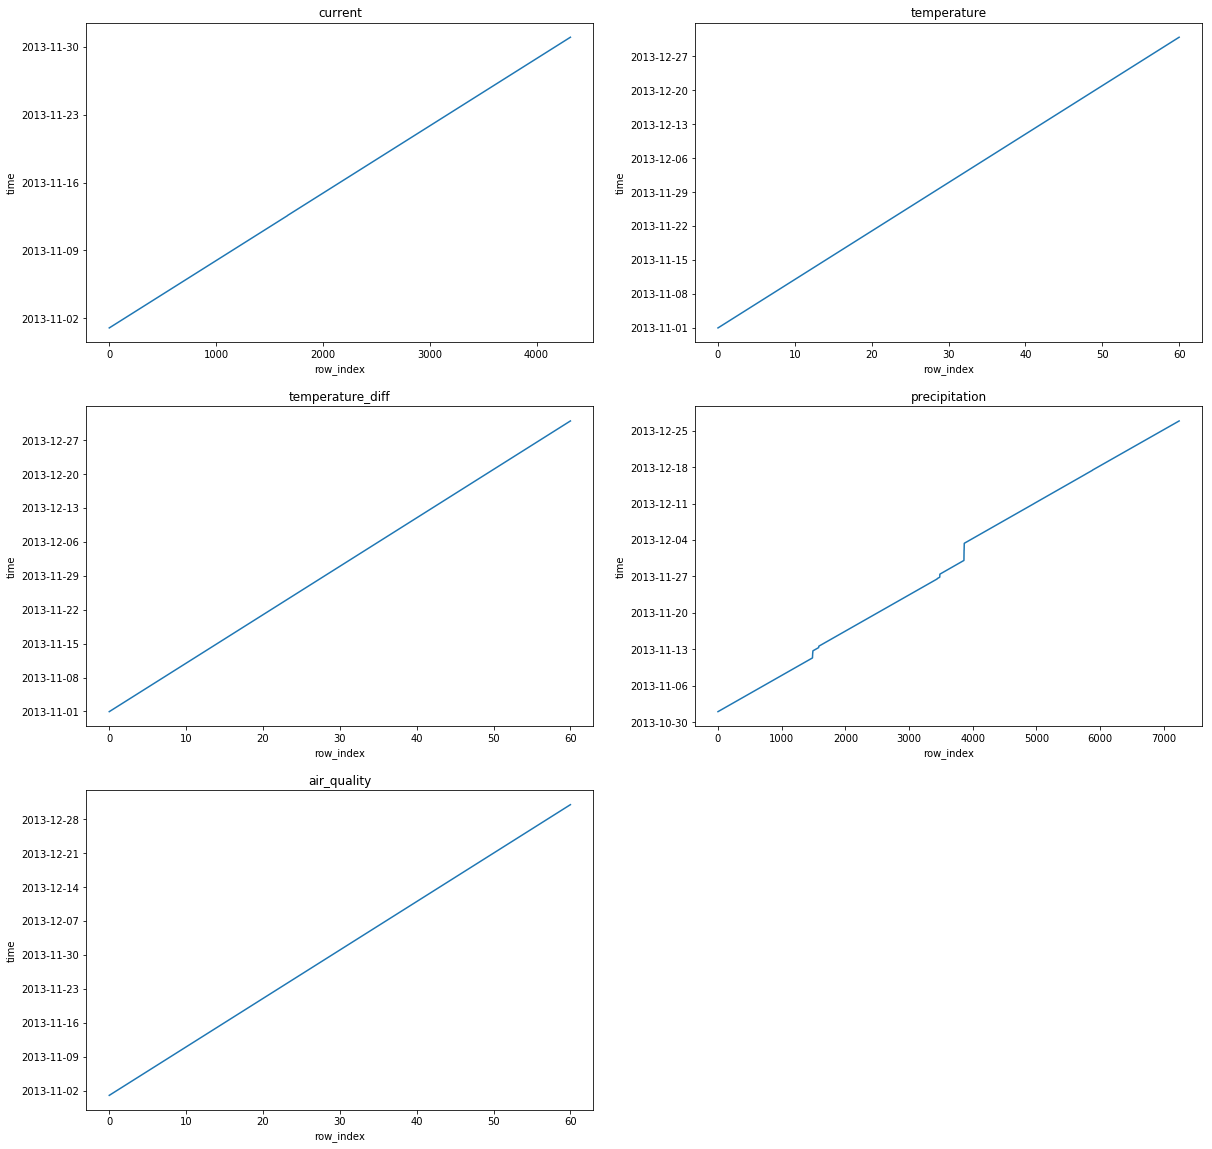

In [3]:
def plot_time(elements,ele):
    fig = plt.figure(figsize=(20,20)) 
    for i,e in enumerate(elements):
        plt.subplot(3,2,i+1)
        plt.title(ele[i])
        plt.xlabel("row_index")
        plt.ylabel("time")
        plt.plot(e['timestamp'])
        print("{}:  min is {} and max is {}".format(ele[i],np.min(e['timestamp']),np.max(e['timestamp']))) 
plot_time(elements,ele)

In [4]:
def time_synchronize(dfs):
    min_max = np.max([np.min(df['timestamp']) for df in dfs])
    max_min = np.min([np.max(df['timestamp']) for df in dfs])  
    print ('common time is from {} to {}'.format(min_max,max_min))
    synchronized_dfs = []
    for df in dfs:
        df = df.sort_values(['timestamp'])
        df = df.loc[(df['timestamp']<=max_min)&(df['timestamp']>=min_max)]
        print(df['timestamp'].iloc[0])
        df['hour'] = df['timestamp'].dt.hour
        df['date'] = df['timestamp'].dt.date
        synchronized_dfs.append(df)
    return synchronized_dfs

synchronized_elements = time_synchronize(elements)

# calculate the time difference between each element
delta_t = [[d/np.timedelta64(1, 'h') for d in np.diff(elem['timestamp'])] for elem in synchronized_elements]
median_time_differerences = [np.median(elem) for elem in delta_t]
for i in range(len(median_time_differerences)):
    print ("the difference for %s in hours is %.6f hour"%(ele[i],median_time_differerences[i]))

common time is from 2013-11-01 00:00:00 to 2013-11-30 23:50:00
2013-11-01 00:00:00
2013-11-01 23:00:00
2013-11-01 23:00:00
2013-11-01 00:00:00
2013-11-01 00:00:00
the difference for current in hours is 0.166667 hour
the difference for temperature in hours is 24.000000 hour
the difference for temperature_diff in hours is 24.000000 hour
the difference for precipitation in hours is 0.166667 hour
the difference for air_quality in hours is 24.000000 hour


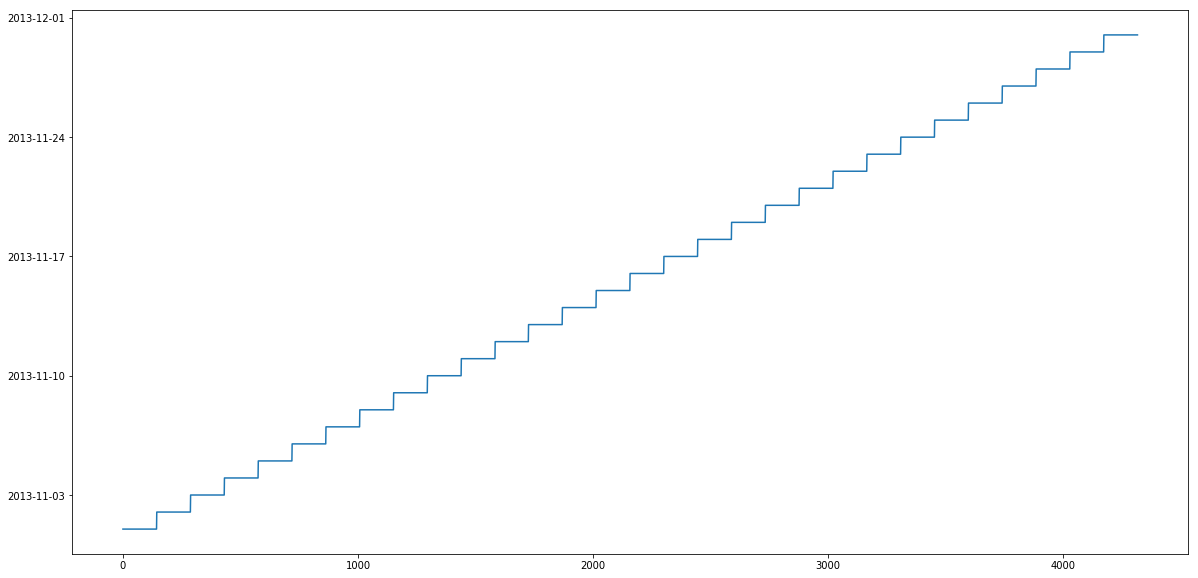

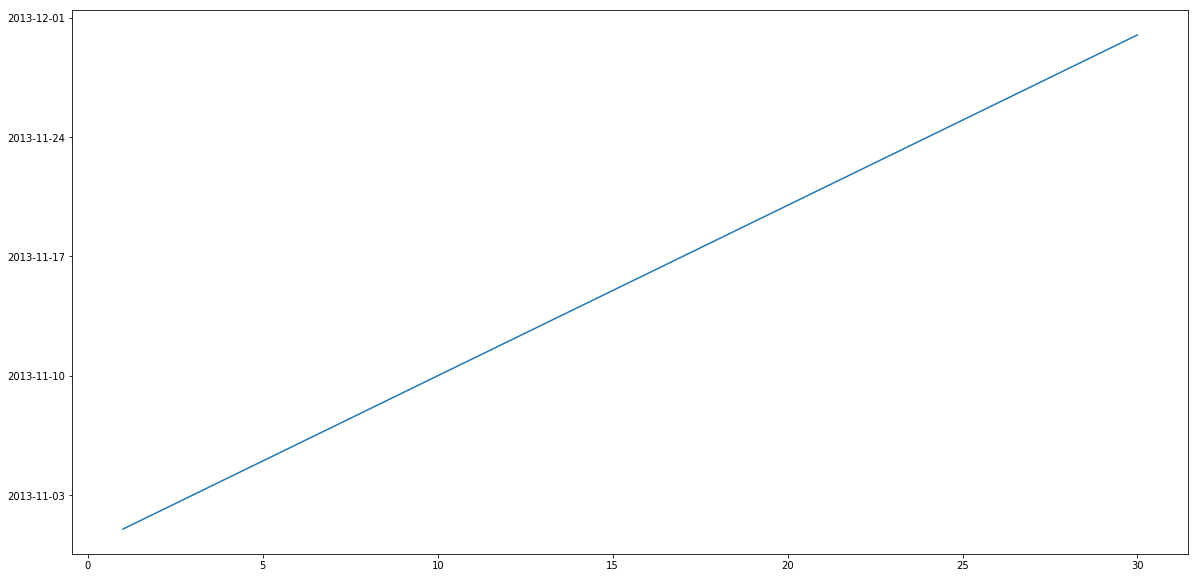

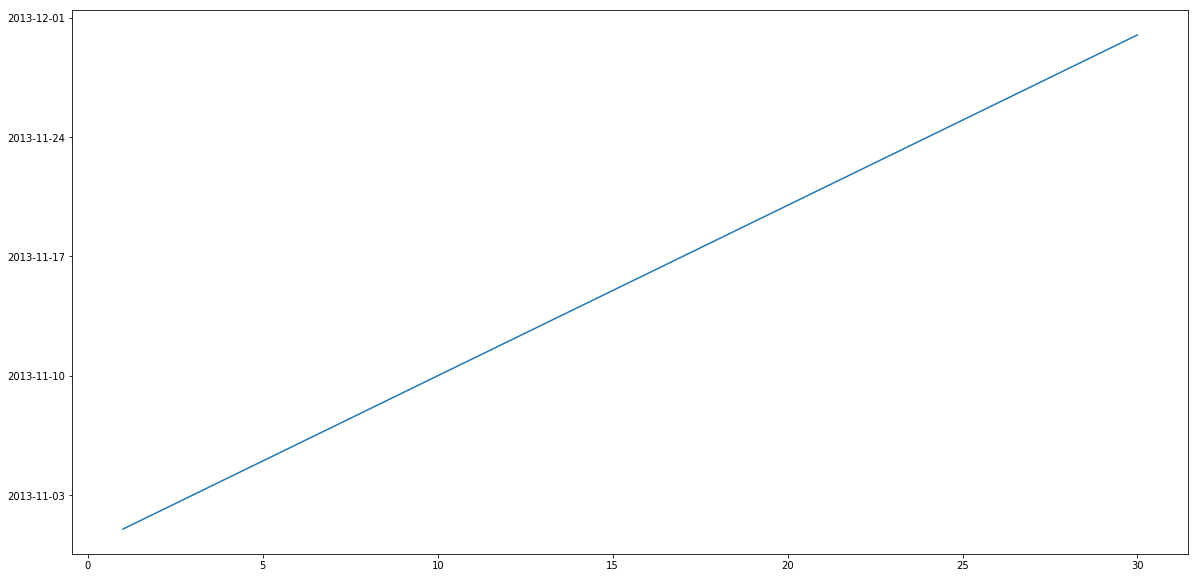

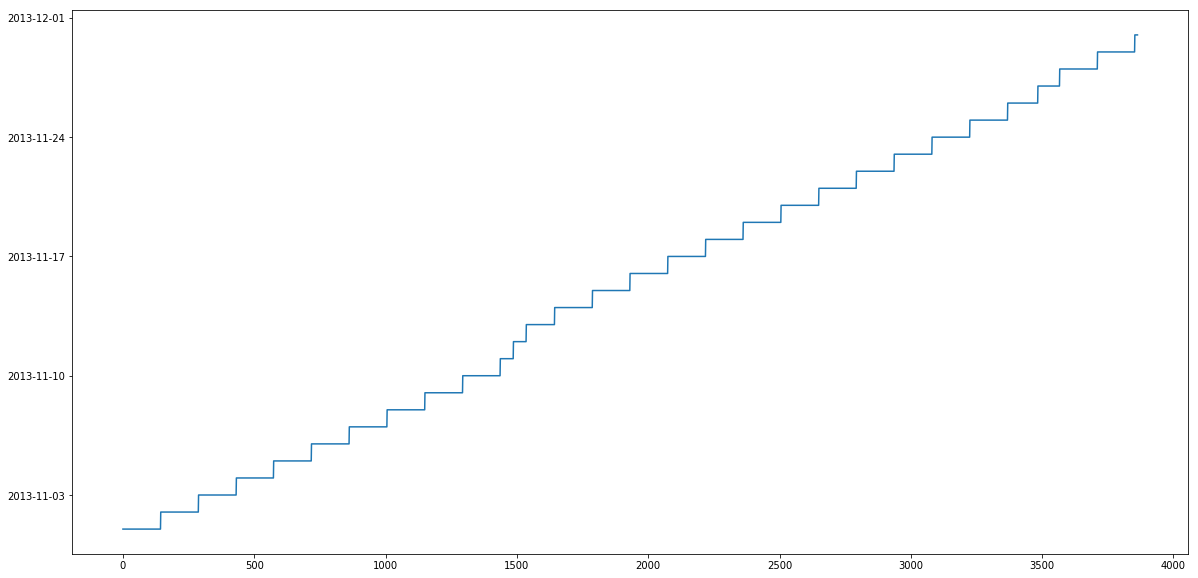

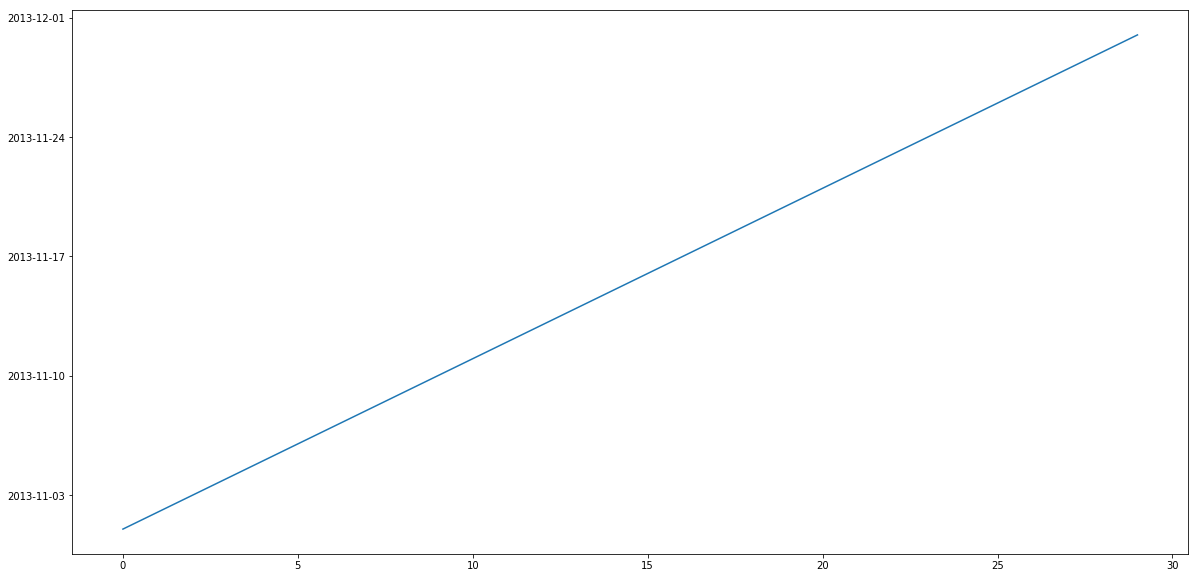

In [12]:
for df in synchronized_elements:
    plt.figure(figsize=(20,10))
    plt.plot(df.date)
    plt.show()

In [5]:
# find the comman grid
def calculate_comman_grid(synchronized_elements2):
    a = synchronized_elements2[0].columns
    for i in range(1,len(synchronized_elements2)):
        current = synchronized_elements2[i]
        a = list(current.columns[current.columns.isin(a)])
    return a

common_grids = calculate_comman_grid(synchronized_elements)
common_grids
# common_grids = np.array(common_grids).astype(str)

['timestamp',
 '2972',
 '3077',
 '3215',
 '3911',
 '5067',
 '5073',
 '5111',
 '5202',
 '5550',
 '6225',
 '6367',
 '6720',
 'hour',
 'date']

In [6]:
choose = ['timestamp','5550','2972','5202','3215','5111','hour','date']
def select_common(dfs,c):
    df_l = []
    for df in dfs:
        common = df.loc[:,df.columns.isin(c)]
        df_l.append(common)
    return df_l
selected_elements_list = select_common(synchronized_elements,choose)

In [7]:
[common_current,common_temperature,common_temperature_diff,common_precipitation,common_air_quality] = selected_elements_list

hourly_current = common_current.groupby(['date','hour']).sum().reset_index()
hourly_precipitation = common_precipitation.groupby(['date','hour']).median().reset_index()
daily_temperature = common_temperature.groupby(['date']).sum().reset_index()
daily_temperature_diff = common_temperature_diff.groupby(['date']).sum().reset_index()
daily_air_quality =  common_air_quality.groupby(['date']).median().reset_index()


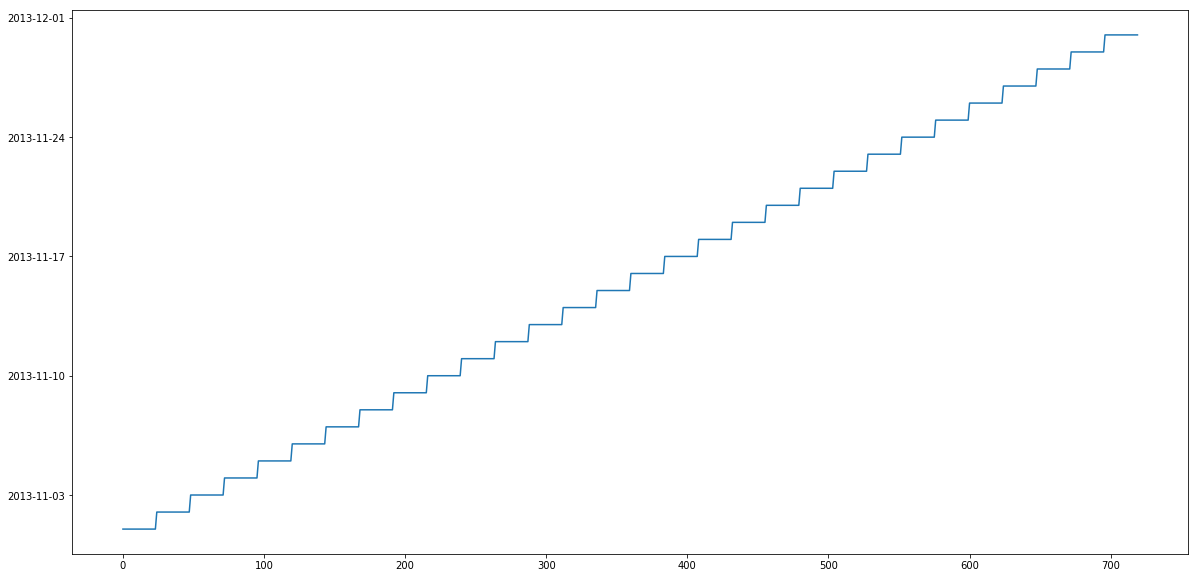

In [13]:
plt.figure(figsize=(20,10))
plt.plot(hourly_current.date)
plt.show()

In [8]:
common_air_quality.head(2)

,timestamp,2972,3215,5111,5202,5550,hour,date
0,2013-11-01,NaN,NaN,NaN,1.714286,1.444444,0,2013-11-01
1,2013-11-02,NaN,NaN,5.0,1.750000,NaN,0,2013-11-02


In [17]:
grid_ids = ['5550','2972','5202','3215','5111']

def merge_df(hourly_current,hourly_precipitation,daily_temperature,
               daily_temperature_diff,daily_air_quality,grid_ids):
    grid_train_data = []
    for id_ in grid_ids:
        f = ['date','hour',id_]
        g = ['date',id_]
        h = hourly_current[f].merge(hourly_precipitation[f],on=['date','hour'],how='left')
        h2 = h.merge(daily_temperature[g],on=['date'],how='left')
        h2 = h2.merge(daily_temperature_diff[g],on=['date'],how='left')
        h3 = h2.merge(daily_air_quality[g],on=['date'],how='left')
        h3.columns=['date','hour','current','precipitation','temperature','temperature_diff','air_quality']
        grid_train_data.append(h3)
    return grid_train_data

overall_dfs = merge_df(hourly_current,hourly_precipitation,daily_temperature,
               daily_temperature_diff,daily_air_quality,grid_ids)

for i,df in enumerate(overall_dfs):
    name = grid_ids[i]
    df.to_csv('%s.csv'%name,index=False)

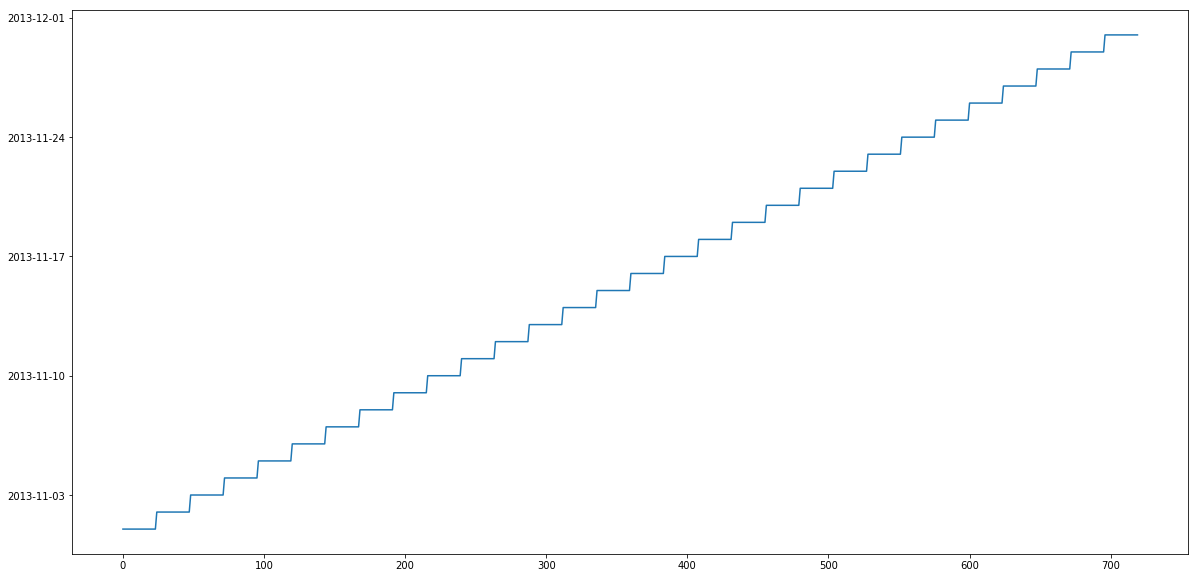

In [16]:
plt.figure(figsize=(20,10))
plt.plot(hourly_current.date)
plt.show()